In [3]:
import sys
sys.path.insert(0,'..')
from classifier_config import ClassifierConfig
from feature_extractor import FeatureExtractor
from model_trainer import ModelTrainer
from wsa_classifier import WordSenseAlignmentClassifier

In [4]:
english_config = ClassifierConfig('en_core_web_lg', "english", '../data/train', balancing_strategy="none", testset_ratio=0.2, logger = 'default')
feature_extractor = FeatureExtractor() \
    .first_word() \
    .similarity() \
    .diff_pos_count() \
    .tfidf() \
    .ont_hot_pos() \
    .matching_lemma() \
    .count_each_pos() \
    .cosine() \
    .jaccard() \
    .avg_count_synsets()\
    .difference_in_length()

model_trainer = ModelTrainer(english_config.testset_ratio, english_config.logger)

english_classifier = WordSenseAlignmentClassifier(english_config, feature_extractor, model_trainer)
data = english_classifier.load_data().get_preprocessed_data()

FileNotFoundError: [Errno 2] No such file or directory: '/Users/seungbinyim/Development/repos/codalab/Codalab/jupyter/reports/english_none_False_20200316-132340_.log'

In [29]:
data[data['def2'].map(lambda row: ';' in row) == True]
data['processed_2']
def count_semicolon(doc):
    return len([token for token in doc if token.text is ';'])

data['semicol_count'] = data['processed_2'].map(lambda doc: count_semicolon(doc))
data['semicol_count']


0      1
1      0
2      0
3      1
4      0
      ..
551    0
552    0
553    0
554    0
555    0
Name: semicol_count, Length: 556, dtype: int64

In [45]:
doc = data['processed_2'][data['def2'].map(lambda row: ';' in row) == True].iloc[0]
print([token.pos_ for token in doc])

['ADV', 'ADP', 'PUNCT', 'ADV', 'ADP']


In [3]:
feats = feature_extractor.extract(data, feats_to_scale = ['similarities', 'len_diff', 'pos_diff'])
x_trainset, x_testset = model_trainer.split_data(feats, english_config.testset_ratio)
y_trainset, y_testset = model_trainer.split_data(data['relation'], english_config.testset_ratio)

In [4]:
feats.columns

Index(['first_word_same', 'similarities', 'pos_diff', 'cos_tfidf',
       'interjection', 'pronoun', 'adjective', 'noun', 'adverb', 'conjunction',
       'number', 'verb', 'preposition', 'lemma_match_normalized', 'ADP', 'ADV',
       'PUNCT', 'ADJ', 'X', 'INTJ', 'NUM', 'SYM', 'SCONJ', 'DET', 'VERB',
       'AUX', 'PART', 'CCONJ', 'PROPN', 'NOUN', 'PRON', 'cos', 'jaccard',
       'synset_count_1', 'synset_count_2', 'len_diff'],
      dtype='object')

In [5]:
feats['similarities'].plot.kde()
#feats['jaccard'].plot.kde()
#feats['len_diff'].plot.kde()
#feats['pos_diff'].plot.kde()
#feats['cos'].plot.kde()
#feats['cos_tfidf'].plot.kde()

/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


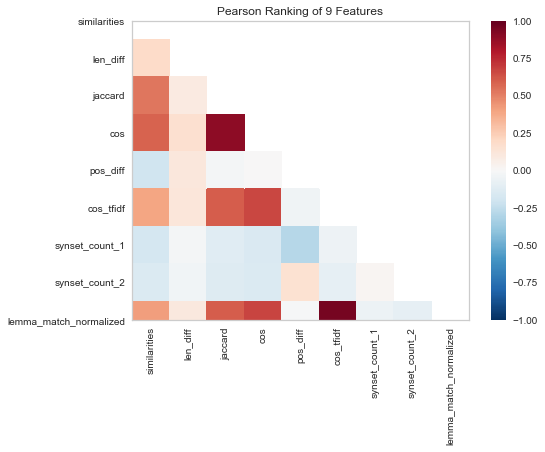

In [6]:
feats
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D
from yellowbrick.datasets import load_credit

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

#X = ['pd']['x_trainset']
#print(X)
X = feats[['similarities','len_diff','jaccard','cos','pos_diff','cos_tfidf', 'synset_count_1', 'synset_count_2','lemma_match_normalized']]

visualizer.fit(X, y_trainset)  
visualizer.transform(X) 
visualizer.show()

In [48]:
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import classification_report, confusion_matrix, f1_score
model = RandomForestClassifier(bootstrap= True, max_depth=30, max_features=None, min_samples_leaf=3, min_samples_split=2, n_estimators=600)
model.fit(x_trainset, y_trainset)
predicted = model.predict(x_testset)
print(str(classification_report(y_testset, predicted)))
print(str(confusion_matrix(y_testset, predicted)))
print(str(f1_score(y_testset, predicted, average='weighted')))
score = model.score(x_testset, y_testset)
print('\t\t' + "Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')

              precision    recall  f1-score   support

     broader       0.00      0.00      0.00         2
       exact       0.43      0.38      0.40         8
    narrower       0.00      0.00      0.00         5
        none       0.92      0.99      0.95        96

    accuracy                           0.88       111
   macro avg       0.34      0.34      0.34       111
weighted avg       0.83      0.88      0.85       111

[[ 0  1  0  1]
 [ 0  3  0  5]
 [ 0  3  0  2]
 [ 0  0  1 95]]
0.8545792023178957
		Accuracy: 0.8829 (+/- 0.0000)



/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [49]:
model_2 = RandomForestClassifier(bootstrap= True, class_weight = 'balanced_subsample', max_depth=80, max_features=2, min_samples_leaf=3, min_samples_split=5, n_estimators=800)
model_2.fit(x_trainset, y_trainset)
predicted = model.predict(x_testset)
print(str(classification_report(y_testset, predicted)))
print(str(confusion_matrix(y_testset, predicted)))
print(str(f1_score(y_testset, predicted, average='weighted')))
score = model.score(x_testset, y_testset)
print('\t\t' + "Accuracy: %0.4f (+/- %0.4f)" % (score.mean(), score.std() * 2) + '\n')
print('BASELINE:' + str(model_trainer.get_baseline_df(y_testset)))

              precision    recall  f1-score   support

     broader       0.00      0.00      0.00         2
       exact       0.43      0.38      0.40         8
    narrower       0.00      0.00      0.00         5
        none       0.92      0.99      0.95        96

    accuracy                           0.88       111
   macro avg       0.34      0.34      0.34       111
weighted avg       0.83      0.88      0.85       111

[[ 0  1  0  1]
 [ 0  3  0  5]
 [ 0  3  0  2]
 [ 0  0  1 95]]
0.8545792023178957
		Accuracy: 0.8829 (+/- 0.0000)

BASELINE:0.8648648648648649


/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


**Load Spacy Language Model.**

In our case it is the large english model

In [2]:
nlp = spacy.load('en_core_web_lg')

**Load Dataset and preprocess it**

The preprocessing step consists of sampling strategy, default one being oversampling, and nlp pipeline(stopwords removal, lemmatizer, pos tagging)

In [3]:
en_data = load_and_preprocess('english', nlp)
print(set(en_data['relation']))

20                                 (away, from, a, place)
3025    ((, often, follow, by, `, to, ', ), above, be,...
382                        (touch, the, surface, of, sth)
4438             (of, or, involve, the, home, or, family)
256     ((, of, a, store, ,, business, ,, etc, ., ), a...
                              ...                        
3120    (perennial, marsh, plant, have, swordlike, lea...
8052    (a, ball, of, fire, (, such, as, the, sun, or,...
102     (in, sport, ,, relate, to, action, or, team, m...
4107    (make, something, ,, usually, for, a, specific...
5048    (come, as, a, logical, consequence, ;, follow,...
Name: lemmatized_1, Length: 2240, dtype: object
20                                          [away, place]
3025                       [follow, `, affect, influence]
382                                 [touch, surface, sth]
4438                              [involve, home, family]
256     [store, business, etc, available, business, pr...
                        

**Print only narrower relations**

In [4]:
is_narrower = en_data['relation']=='narrower'
print(en_data[has_label(en_data,'narrower')])

             word        pos  \
3025     superior  adjective   
1661         rush       verb   
5301      gushing  adjective   
12    commentator       noun   
3502  recognition       noun   
...           ...        ...   
5744          rag       verb   
104         allow       verb   
1584         sack       noun   
3120      calamus       noun   
5048       follow       verb   

                                                   def1  \
3025  (often followed by `to') above being affected ...   
1661                         urge to an unnatural speed   
5301                        extravagantly demonstrative   
12    a writer who reports and analyzes events of th...   
3502  coming to understand something clearly and dis...   
...                                                 ...   
5744                                    play in ragtime   
104   give or assign a resource to a particular pers...   
1584  a bag made of paper or plastic for holding cus...   
3120  perennial marsh pla

**Enrich Dataframe with spacy nlp processed columns**

In [5]:
label_count = en_data.groupby('relation').count().word.sort_values(ascending=False)
label_count.plot(kind = 'bar')
label_count[1]
#label_count.plot(kind = 'bar', x = 'relation', y )

448

In [6]:
features = extract_features(en_data, feats_to_scale = ['similarities', 'len_diff', 'pos_diff'])


In [7]:
print(features)


      similarities  first_word_same  len_diff   jaccard       cos  pos_diff  \
20       -1.360503            False -0.893043  0.000000  0.000000  0.560154   
3025      0.858271            False -0.147546  0.083333  0.421350 -0.804442   
382      -1.412957            False -0.893043  0.000000  0.000000 -0.122144   
4438      0.666514            False -0.644544  0.133333  0.384900  0.219005   
256      -1.089819            False  1.094948  0.000000  0.000000  2.607049   
...            ...              ...       ...       ...       ...       ...   
3120      0.116266            False  0.846449  0.069767  0.228934 -2.169038   
8052      0.940398             True  2.088944  0.162162  0.415775 -0.122144   
102      -3.391493            False -0.644544  0.000000  0.000000  2.265900   
4107      0.275805            False  0.100953  0.000000  0.000000  0.901304   
5048      0.623860            False  0.100953  0.117647  0.089087  0.219005   

      cos_tfidf  
20     0.000000  
3025   0.438204

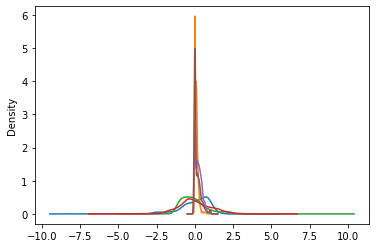

In [8]:
features['similarities'].plot.kde()
features['jaccard'].plot.kde()
features['len_diff'].plot.kde()
features['pos_diff'].plot.kde()
features['cos'].plot.kde()
features['cos_tfidf'].plot.kde()

In [46]:
#features['similarities'].plot.hist()
#features['jaccard'].plot.hist()
#features['len_diff'].plot.hist()
#features['pos_diff'].plot.hist()
features['cos'].plot.hist()
#features['cos_tfidf'].plot.hist()

NameError: name 'features' is not defined

In [10]:
def is_above_threshold(df, column,threshold):
    return df[column] >= threshold

en_data[is_above_threshold(features,'cos_tfidf', 0.1) == False]

,word,pos,def1,def2,relation,processed_1,processed_2,lemmatized_1,stopwords_removed_1,lemmatized_2,stopwords_removed_2
20,off,adverb,away from a place,(of food) rotten,none,"(away, from, a, place)","((, of, food, ), rotten)","(away, from, a, place)","[away, place]","((, of, food, ), rotten)","[food, rotten]"
382,on,preposition,touching the surface of sth,"when (something is, or has been, done)",none,"(touching, the, surface, of, sth)","(when, (, something, is, ,, or, has, been, ,, ...","(touch, the, surface, of, sth)","[touch, surface, sth]","(when, (, something, be, ,, or, have, be, ,, d...",[]
256,open,adjective,"(of a store, business, etc.) available for bus...",not kept secret,none,"((, of, a, store, ,, business, ,, etc, ., ), a...","(not, kept, secret)","((, of, a, store, ,, business, ,, etc, ., ), a...","[store, business, etc, available, business, pr...","(not, keep, secret)",[secret]
492,on,preposition,hitting against,by means of,none,"(hitting, against)","(by, means, of)","(hit, against)",[hit],"(by, mean, of)",[mean]
856,oriflamme,noun,an inspiring symbol or ideal that serves as a ...,"a standard or ensign, in battle.",related,"(an, inspiring, symbol, or, ideal, that, serve...","(a, standard, or, ensign, ,, in, battle, .)","(an, inspiring, symbol, or, ideal, that, serve...","[inspiring, symbol, ideal, serve, rallying, po...","(a, standard, or, ensign, ,, in, battle, .)","[standard, ensign, battle]"
...,...,...,...,...,...,...,...,...,...,...,...
1515,empty,verb,become empty or void of its content,to discharge itself; .,broader,"(become, empty, or, void, of, its, content)","(to, discharge, itself, ;, .)","(become, empty, or, void, of, content)","[void, content]","(to, discharge, ;, .)",[discharge]
8052,fireball,noun,a ball of fire (such as the sun or a ball-shap...,a large mass of fire caused by a large explosi...,broader,"(a, ball, of, fire, (, such, as, the, sun, or,...","(a, large, mass, of, fire, caused, by, a, larg...","(a, ball, of, fire, (, such, as, the, sun, or,...","[ball, fire, sun, ball, shape, discharge, ligh...","(a, large, mass, of, fire, cause, by, a, large...","[large, mass, fire, cause, large, explosion, i..."
102,offensive,adjective,"in sports, relating to actions or team members...",insulting,none,"(in, sports, ,, relating, to, actions, or, tea...",(insulting),"(in, sport, ,, relate, to, action, or, team, m...","[sport, relate, action, team, member, score, p...",(insult),[insult]
4107,work,verb,"make something, usually for a specific function",to produce or form by labor; to bring forth by...,exact,"(make, something, ,, usually, for, a, specific...","(to, produce, or, form, by, labor, ;, to, brin...","(make, something, ,, usually, for, a, specific...","[usually, specific, function]","(to, produce, or, form, by, labor, ;, to, brin...","[produce, form, labor, bring, forth, exertion,..."


In [11]:
all_train_and_testset = prepare_data(features, en_data['relation'])

**Plot Correlation Matrix of features**

      similarities  first_word_same  len_diff   jaccard       cos  pos_diff  \
429       0.217786            False  1.591946  0.000000  0.000000  1.583602   
7507      0.707387            False  3.082939  0.111111  0.134840  1.583602   
7274      1.187363            False  1.343447  0.076923  0.505076 -0.463293   
5506      1.115411            False  2.834440  0.086957  0.175682  0.560154   
2806     -0.830424            False -0.893043  0.000000  0.000000  0.560154   
...            ...              ...       ...       ...       ...       ...   
3120      0.116266            False  0.846449  0.069767  0.228934 -2.169038   
8052      0.940398             True  2.088944  0.162162  0.415775 -0.122144   
102      -3.391493            False -0.644544  0.000000  0.000000  2.265900   
4107      0.275805            False  0.100953  0.000000  0.000000  0.901304   
5048      0.623860            False  0.100953  0.117647  0.089087  0.219005   

      cos_tfidf  
429    0.000000  
7507   0.178606

/Users/seungbinyim/opt/anaconda3/lib/python3.7/site-packages/yellowbrick/features/rankd.py:216: YellowbrickWarning: RankD plots may be clipped when using matplotlib v3.1.1, upgrade to matplotlib v3.1.2 or later to fix the plots.
  warnings.warn(msg, YellowbrickWarning)


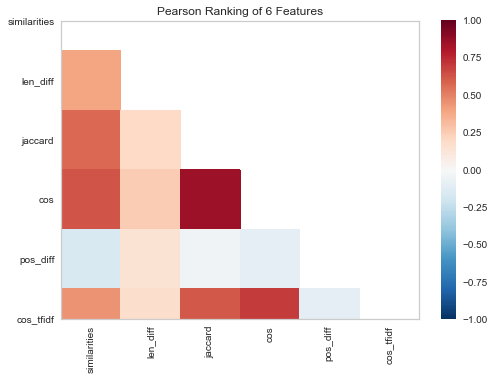

In [12]:
from yellowbrick.classifier import ClassificationReport
from yellowbrick.features import Rank2D
from yellowbrick.datasets import load_credit

# Instantiate the visualizer with the Pearson ranking algorithm
visualizer = Rank2D(algorithm='pearson')

X = all_train_and_testset['pd']['x_trainset']
print(X)
X = X[['similarities','len_diff','jaccard','cos','pos_diff','cos_tfidf']]

visualizer.fit(X, all_train_and_testset['pd']['y_trainset'])  
visualizer.transform(X) 
visualizer.show()

**Plot Confusion Matrix of the classifiers result**

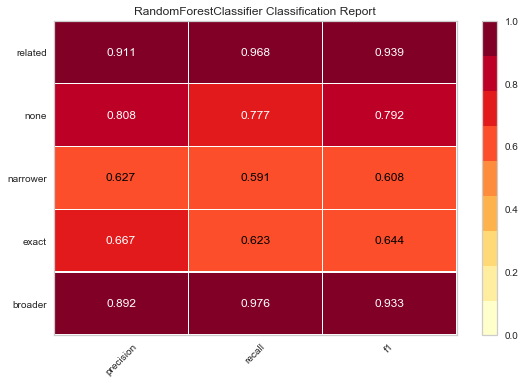

In [13]:
model = RandomForestClassifier(max_depth=15, max_features='auto', min_samples_leaf=3, min_samples_split=2, n_estimators=500)
visualizer = ClassificationReport(model)
visualizer.fit(all_train_and_testset['pd']['x_trainset'], all_train_and_testset['pd']['y_trainset'])
visualizer.score(all_train_and_testset['pd']['x_testset'], all_train_and_testset['pd']['y_testset'])
visualizer.show()